In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as keras
import tensorflow_hub as hub

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
#seed = 42
#tf.random.set_seed(seed)
#np.random.seed(seed)

In [2]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [3]:
!nvidia-smi

Sun Jun 13 15:06:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Download folder and unzip it
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182083584/182082353 [==============================] - 1s 0us/step


In [5]:
# Print commands
commands = []
commands.append('down')
commands.append('go')
commands.append('left')
commands.append('no')
commands.append('right')
commands.append('stop')
commands.append('up')
commands.append('yes')

commands = np.array(commands)#np.array(tf.io.gfile.listdir(str(data_dir)))
#commands = commands[commands != 'README.md']
print('Commands:', commands)

# Shuffle audio samples and print some info
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
print(type(filenames))
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
<class 'tensorflow.python.framework.ops.EagerTensor'>
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/c103a2d5_nohash_1.wav', shape=(), dtype=string)


In [6]:
'''
The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.
To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.
A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time.
In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. 
Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].
'''
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label_in_integer(file_path):
  label = get_label(file_path)
  #print(label.numpy().decode('utf-8'))
  label = tf.argmax(label == commands)
  label = tf.cast(label, tf.int32)  
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# We need the waveforms to have a similar length.
# This can be done by simply zero padding the audio clips that are shorter than one second.

def zero_pad_the_waveforms(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  return equal_length

In [7]:
train_x = []
train_y = []

for i in filenames:
  #print(i)
  train_x.append(zero_pad_the_waveforms(get_waveform_and_label_in_integer(i)[0]))
  train_y.append(get_waveform_and_label_in_integer(i)[1])

In [8]:
print(len(train_x))
print(filenames[:7])
print(train_x[:7])
print(train_y[:7])

8000
tf.Tensor(
[b'data/mini_speech_commands/no/c103a2d5_nohash_1.wav'
 b'data/mini_speech_commands/left/b087aa0e_nohash_0.wav'
 b'data/mini_speech_commands/left/c37a72d3_nohash_2.wav'
 b'data/mini_speech_commands/left/11b1df78_nohash_1.wav'
 b'data/mini_speech_commands/down/0132a06d_nohash_1.wav'
 b'data/mini_speech_commands/down/b19f7f5f_nohash_1.wav'
 b'data/mini_speech_commands/yes/4f2be90f_nohash_0.wav'], shape=(7,), dtype=string)
[<tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.0050354 , -0.0067749 , -0.00576782, ...,  0.00259399,
        0.00476074,  0.00680542], dtype=float32)>, <tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([-0.0005188 , -0.00091553, -0.00064087, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)>, <tf.Tensor: shape=(16000,), dtype=float32, numpy=
array([ 3.0517578e-05, -1.5258789e-04, -1.8310547e-04, ...,
        1.1901855e-03,  1.2207031e-03,  1.4038086e-03], dtype=float32)>, <tf.Tensor: shape=(16000,), dtype=float32, num

In [9]:
train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)
print(len(train_x))
print(len(train_y))

8000
8000


In [10]:
print(train_x[:4])
print(train_y[:4])

tf.Tensor(
[[-5.0354004e-03 -6.7749023e-03 -5.7678223e-03 ...  2.5939941e-03
   4.7607422e-03  6.8054199e-03]
 [-5.1879883e-04 -9.1552734e-04 -6.4086914e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0517578e-05 -1.5258789e-04 -1.8310547e-04 ...  1.1901855e-03
   1.2207031e-03  1.4038086e-03]
 [-9.3994141e-03 -9.8571777e-03 -1.0894775e-02 ... -1.1840820e-02
  -9.3994141e-03 -9.9792480e-03]], shape=(4, 16000), dtype=float32)
tf.Tensor([3 2 2 2], shape=(4,), dtype=int32)


In [ ]:
numpy_y = train_y.numpy()
print(numpy_y)
print(tf.convert_to_tensor(numpy_y[:4]))

[5 4 0 ... 3 3 7]
tf.Tensor([5 4 0 3], shape=(4,), dtype=int32)


# Yamnet

In [11]:
# Download the model from TFHub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [12]:
# Print the classes
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [18]:
# applies the embedding extraction model to a wav data
def extract_embedding_data(wav_data):
  ''' run YAMNet to extract embedding from the wav data '''
  #print(len(wav_data))
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  #num_embeddings = tf.shape(embeddings)[0]
  return embeddings

# applies the embedding extraction model to a wav data
def extract_embedding_data_one_output(wav_data):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  embeddings = tf.reduce_mean(embeddings, 0)
  return embeddings

new_array = []

for i in train_x:
  #print(len(i))
  new_array.append(extract_embedding_data_one_output(i))
  #new_array.append(extract_embedding_data(i))

yamnet_train_x = tf.convert_to_tensor(new_array)


In [19]:
print(len(yamnet_train_x))
print(yamnet_train_x[:1])

8000
tf.Tensor([[0.03142092 0.39526838 0.13033617 ... 0.3167366  0.0062078  0.        ]], shape=(1, 1024), dtype=float32)


In [20]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(commands))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4104      
Total params: 528,904
Trainable params: 528,904
Non-trainable params: 0
_________________________________________________________________


In [21]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [22]:
history = my_model.fit(yamnet_train_x,train_y,
                       epochs=40,
                       validation_split=0.2,
                       callbacks=callback,
                       batch_size=32,
                       verbose=1)

Epoch 1/40
200/200 [==============================] - 1s 3ms/step - loss: 1.8171 - accuracy: 0.3327 - val_loss: 1.6459 - val_accuracy: 0.4375
Epoch 2/40
200/200 [==============================] - 0s 2ms/step - loss: 1.5309 - accuracy: 0.4447 - val_loss: 1.4570 - val_accuracy: 0.4800
Epoch 3/40
200/200 [==============================] - 0s 2ms/step - loss: 1.3991 - accuracy: 0.4972 - val_loss: 1.4453 - val_accuracy: 0.4725
Epoch 4/40
200/200 [==============================] - 0s 2ms/step - loss: 1.3278 - accuracy: 0.5300 - val_loss: 1.3791 - val_accuracy: 0.5138
Epoch 5/40
200/200 [==============================] - 0s 2ms/step - loss: 1.2625 - accuracy: 0.5461 - val_loss: 1.3292 - val_accuracy: 0.5131
Epoch 6/40
200/200 [==============================] - 0s 2ms/step - loss: 1.1963 - accuracy: 0.5698 - val_loss: 1.2915 - val_accuracy: 0.5294
Epoch 7/40
200/200 [==============================] - 0s 2ms/step - loss: 1.1404 - accuracy: 0.5881 - val_loss: 1.3006 - val_accuracy: 0.5256
Epoch 

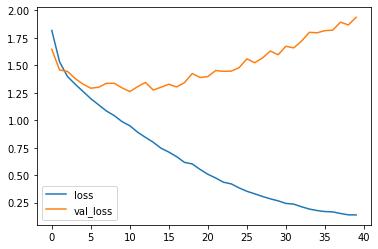

In [23]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
scores, embeddings, spectrogram = yamnet_model(zero_pad_the_waveforms(get_waveform_and_label_in_integer('/content/data/mini_speech_commands/right/0227998e_nohash_0.wav')[0]))
print(embeddings)
embeddings = tf.reduce_mean(embeddings, 0)
result = my_model(embeddings).numpy()
print(result)

#infered_class = commands[result.mean(axis=0).argmax()]
#print(f'The main sound is: {infered_class}')

tf.Tensor(
[[0.05651987 0.07747456 0.         ... 0.         0.03957902 0.        ]
 [0.10405616 0.13227785 0.3524423  ... 0.22695433 0.         0.        ]], shape=(2, 1024), dtype=float32)


ValueError: ignored